In [1]:
# https://pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/

In [4]:
# import the necessary packages
import torch.nn as nn

from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torch.optim import SGD
from torch.optim import Adam

#!pip install torchsummary
from torchsummary import summary

from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
print("Torch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("GPU:", torch.cuda.device_count(), torch.cuda.get_device_name(0)) if torch.cuda.is_available() else print("NO GPU")

Torch: 1.8.2+cu102
Torchvision: 0.9.2+cu102
GPU: 1 Quadro RTX 3000 with Max-Q Design


In [5]:
class LeNet(Module):
    def __init__(self, numChannels, classes):
        # call the parent constructor
        super(LeNet, self).__init__()

        # initialize first set of CONV => RELU => POOL layers
        self.conv1 = Conv2d(in_channels=numChannels, out_channels=20, kernel_size=(5, 5))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
                                  
        # initialize second set of CONV => RELU => POOL layers
        self.conv2 = Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
                                  
        # initialize first (and only) set of FC => RELU layers
        self.fc1 = Linear(in_features=800, out_features=500)
        self.relu3 = ReLU()
                                  
        # initialize our softmax classifier
        self.fc2 = Linear(in_features=500, out_features=classes)
        self.logSoftmax = LogSoftmax(dim=1)
        
    def forward(self, x):
        # pass the input through our first set of CONV => RELU => POOL layers
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # pass the output from the previous layer through the second set of CONV => RELU => POOL layers
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        # flatten the output from the previous layer and pass it through our only set of FC => RELU layers
        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)

        # pass the output to our softmax classifier to get our output predictions
        x = self.fc2(x)
        output = self.logSoftmax(x)

        # return the output predictions
        return output

In [11]:
# define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10

# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT

# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
# load the KMNIST dataset
print("[INFO] loading the KMNIST dataset...")
trainData = KMNIST(root="data", train=True, download=True, transform=ToTensor())
testData = KMNIST(root="data", train=False, download=True, transform=ToTensor())

[INFO] loading the KMNIST dataset...


  0%|          | 0/18165135 [00:00<?, ?it/s]

Extracting data\KMNIST\raw\train-images-idx3-ubyte.gz to data\KMNIST\raw



  0%|          | 0/29497 [00:00<?, ?it/s]

Extracting data\KMNIST\raw\train-labels-idx1-ubyte.gz to data\KMNIST\raw



  0%|          | 0/3041136 [00:00<?, ?it/s]

Extracting data\KMNIST\raw\t10k-images-idx3-ubyte.gz to data\KMNIST\raw



  0%|          | 0/5120 [00:00<?, ?it/s]

Extracting data\KMNIST\raw\t10k-labels-idx1-ubyte.gz to data\KMNIST\raw

Processing...


C:\Users\zhanghe\Anaconda3\envs\yolov6_v3\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [16]:
# show train Dataset
trainData

Dataset KMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [17]:
# calculate the train/validation split
print("[INFO] generating the train/validation split...")
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numValSamples = int(len(trainData) * VAL_SPLIT)
(trainData, valData) = random_split(trainData, [numTrainSamples, numValSamples], generator=torch.Generator().manual_seed(42))

[INFO] generating the train/validation split...


In [22]:
# show train Dataset subset
trainData

In [23]:
trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

print(trainSteps, valSteps)

703 234


In [51]:
# initialize the LeNet model
print("[INFO] initializing the LeNet model...")
model = LeNet(numChannels=1, classes=len(trainData.dataset.classes)).to(device)
model

[INFO] initializing the LeNet model...


LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)

In [52]:
# check Pytorch model summary 
# note by He Zhang: input must be (1, 28, 28) as that makes flattened dim = 800, matching the input of the following fc1 layer!!!
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
              ReLU-2           [-1, 20, 24, 24]               0
         MaxPool2d-3           [-1, 20, 12, 12]               0
            Conv2d-4             [-1, 50, 8, 8]          25,050
              ReLU-5             [-1, 50, 8, 8]               0
         MaxPool2d-6             [-1, 50, 4, 4]               0
            Linear-7                  [-1, 500]         400,500
              ReLU-8                  [-1, 500]               0
            Linear-9                   [-1, 10]           5,010
       LogSoftmax-10                   [-1, 10]               0
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 1.64
Estimated T

In [56]:
# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=INIT_LR)
lossFn = nn.NLLLoss()

# initialize a dictionary to store training history
H = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

In [70]:
%%time
# loop over our epochs
for e in range(0, EPOCHS):
    # set the model in training mode
    model.train()
    
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    
    # initialize the number of correct predictions in the training and validation step
    trainCorrect = 0
    valCorrect = 0
    
    # loop over the training set
    for (x, y) in trainDataLoader:
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        
        # perform a forward pass and calculate the training loss
        pred = model(x)
        loss = lossFn(pred, y)
       
        # zero out the gradients, perform the backpropagation step, and update the weights
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # add the loss to the total training loss so far and calculate the number of correct predictions
        totalTrainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(
            torch.float).sum().item()
        
    # switch off autograd for evaluation
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        
        # loop over the validation set
        for (x, y) in valDataLoader:
            
            # send the input to the device
            (x, y) = (x.to(device), y.to(device))
            
            # make the predictions and calculate the validation loss
            pred = model(x)
            totalValLoss += lossFn(pred, y)
            
            # calculate the number of correct predictions
            valCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()
      
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    
    # calculate the training and validation accuracy
    trainCorrect = trainCorrect / len(trainDataLoader.dataset)
    valCorrect = valCorrect / len(valDataLoader.dataset)
    
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_acc"].append(valCorrect)
    
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(avgValLoss, valCorrect))

[INFO] EPOCH: 1/10
Train loss: 0.342923, Train accuracy: 0.8952
Val loss: 0.167156, Val accuracy: 0.9492

[INFO] EPOCH: 2/10
Train loss: 0.098809, Train accuracy: 0.9705
Val loss: 0.105555, Val accuracy: 0.9685

[INFO] EPOCH: 3/10
Train loss: 0.057815, Train accuracy: 0.9824
Val loss: 0.087579, Val accuracy: 0.9739

[INFO] EPOCH: 4/10
Train loss: 0.039498, Train accuracy: 0.9874
Val loss: 0.077706, Val accuracy: 0.9783

[INFO] EPOCH: 5/10
Train loss: 0.025001, Train accuracy: 0.9921
Val loss: 0.078724, Val accuracy: 0.9785

[INFO] EPOCH: 6/10
Train loss: 0.018695, Train accuracy: 0.9944
Val loss: 0.085590, Val accuracy: 0.9785

[INFO] EPOCH: 7/10
Train loss: 0.015118, Train accuracy: 0.9947
Val loss: 0.094584, Val accuracy: 0.9779

[INFO] EPOCH: 8/10
Train loss: 0.015546, Train accuracy: 0.9948
Val loss: 0.076153, Val accuracy: 0.9813

[INFO] EPOCH: 9/10
Train loss: 0.011419, Train accuracy: 0.9962
Val loss: 0.080829, Val accuracy: 0.9815

[INFO] EPOCH: 10/10
Train loss: 0.008970, Trai

In [72]:
# we can now evaluate the network on the test set
print("[INFO] evaluating network...")
# turn off autograd for testing evaluation
with torch.no_grad():
    # set the model in evaluation mode
    model.eval()
    
    # initialize a list to store our predictions
    preds = []
    # loop over the test set
    for (x, y) in testDataLoader:
        # send the input to the device
        x = x.to(device)
        # make the predictions and add them to the list
        pred = model(x)
        preds.extend(pred.argmax(axis=1).cpu().numpy())

preds[:5]

[INFO] evaluating network...


[2, 9, 3, 8, 3]

In [74]:
# generate a classification report
print(classification_report(testData.targets.cpu().numpy(), np.array(preds), target_names=testData.classes))

              precision    recall  f1-score   support

           o       0.95      0.95      0.95      1000
          ki       0.91      0.95      0.93      1000
          su       0.95      0.93      0.94      1000
         tsu       0.93      0.98      0.96      1000
          na       0.95      0.94      0.95      1000
          ha       0.97      0.93      0.95      1000
          ma       0.96      0.95      0.95      1000
          ya       0.95      0.98      0.96      1000
          re       0.96      0.96      0.96      1000
          wo       0.98      0.95      0.96      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



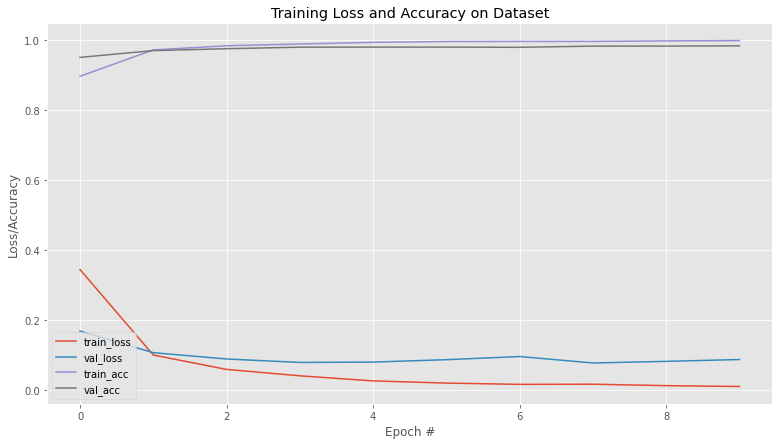

In [90]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure(figsize=(13, 7))
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("./outputs/history.png")

In [87]:
# serialize the model to disk
torch.save(model, "outputs/model.pth")

In [91]:
# make predictions using the saved trained model

In [6]:
# import the necessary packages
import cv2
import torch
import imutils
import numpy as np
np.random.seed(42)

from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST

In [7]:
# set the device we will be using to test the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the KMNIST dataset and randomly grab 10 data points
print("[INFO] loading the KMNIST test dataset...")
testData = KMNIST(root="data", train=False, download=True, transform=ToTensor())
idxs = np.random.choice(range(0, len(testData)), size=(10,))
testData = Subset(testData, idxs)

# initialize the test data loader
testDataLoader = DataLoader(testData, batch_size=1)

# load the model and set it to evaluation mode
model = torch.load("./outputs/model.pth").to(device)
model.eval()

[INFO] loading the KMNIST test dataset...


LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)

In [10]:
# switch off autograd
with torch.no_grad():
    # loop over the test set
    for (image, label) in testDataLoader:
        # grab the original image and ground truth label
        origImage = image.numpy().squeeze(axis=(0, 1))
        gtLabel = testData.dataset.classes[label.numpy()[0]]
        
        # send the input to the device and make predictions on it
        image = image.to(device)
        pred = model(image)
        
        # find the class label index with the largest corresponding probability
        idx = pred.argmax(axis=1).cpu().numpy()[0]
        predLabel = testData.dataset.classes[idx]

        # convert the image from grayscale to RGB (so we can draw on it) 
        # and resize it (so we can more easily see it on our screen)
        origImage = np.dstack([origImage] * 3)
        origImage = imutils.resize(origImage, width=128)

        # draw the predicted class label on it
        color = (0, 255, 0) if gtLabel == predLabel else (0, 0, 255)
        cv2.putText(origImage, gtLabel, (2, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)

        # display the result in terminal and show the input image
        print("[INFO] ground truth label: {}, predicted label: {}".format(gtLabel, predLabel))
        cv2.imshow("image", origImage)
        cv2.waitKey(0)

[INFO] ground truth label: ki, predicted label: ki
[INFO] ground truth label: ki, predicted label: ki
[INFO] ground truth label: ki, predicted label: ki
[INFO] ground truth label: ha, predicted label: ha
[INFO] ground truth label: tsu, predicted label: tsu
[INFO] ground truth label: ya, predicted label: ya
[INFO] ground truth label: tsu, predicted label: tsu
[INFO] ground truth label: na, predicted label: na
[INFO] ground truth label: ki, predicted label: ki
[INFO] ground truth label: tsu, predicted label: tsu
